<a href="https://colab.research.google.com/github/Seonghoon-Yu/Paper_Review_and_Implementation_in_PyTorch/blob/master/Classification/Wide_ResNet(2016).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('wrn')

Mounted at wrn


In [ ]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

# 1. 데이터셋 불러오기

In [ ]:
# specify path to data
path2data = '/content/wrn/MyDrive/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

print(len(train_ds))
print(len(val_ds))

Files already downloaded and verified
Files already downloaded and verified
5000
8000


In [ ]:
# define transformation
transformation = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(64)
])

# apply transformation to dataset
train_ds.transform = transformation
val_ds.transform = transformation

# make dataloade
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

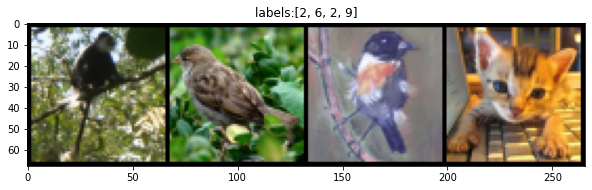

In [ ]:
# check sample images
def show(img, y=None):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels:' + str(y))

np.random.seed(5)
torch.manual_seed(0)

grid_size=4
rnd_ind = np.random.randint(0, len(train_ds), grid_size)

x_grid = [train_ds[i][0] for i in rnd_ind]
y_grid = [val_ds[i][1] for i in rnd_ind]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)
plt.figure(figsize=(10,10))
show(x_grid, y_grid)

# 2. 모델 구축하기
코드는 https://github.com/weiaicunzai/pytorch-cifar100/blob/master/models/wideresidual.py 를 참고했습니다.

In [ ]:
class WiderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()

        self.residual = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        )

        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1, stride=stride, padding=0)

    def forward(self, x):
        x_shortcut = self.shortcut(x)
        x_res = self.residual(x)
        return x_shortcut + x_res


class WRN(nn.Module):
    def __init__(self, depth=40, k=10, num_classes=10, init_weights=True):
        super().__init__()
        N = int((depth-4)/6)
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.conv2 = self._make_layer(16*k, N, 1)
        self.conv3 = self._make_layer(32*k, N, 2)
        self.conv4 = self._make_layer(64*k, N, 2)
        self.bn = nn.BatchNorm2d(64*k)
        self.relu = nn.ReLU()
        self.avg_pool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(64*k, num_classes)

        # weight initialization
        if init_weights:
            self._weights_initialize()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(WiderBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    # weight initialization
    def _weights_initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def WRN_40_10():
    return WRN(40, 10)


In [ ]:
# check model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
x = torch.randn(3, 3, 64, 64).to(device)
model = WRN_40_10().to(device)
output = model(x)
print(output.size())

torch.Size([3, 10])


In [ ]:
# check model summary
summary(model, (3, 64, 64), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 64, 64]             448
            Conv2d-2          [-1, 160, 64, 64]           2,720
       BatchNorm2d-3           [-1, 16, 64, 64]              32
              ReLU-4           [-1, 16, 64, 64]               0
            Conv2d-5          [-1, 160, 64, 64]          23,200
       BatchNorm2d-6          [-1, 160, 64, 64]             320
              ReLU-7          [-1, 160, 64, 64]               0
           Dropout-8          [-1, 160, 64, 64]               0
            Conv2d-9          [-1, 160, 64, 64]         230,560
       WiderBlock-10          [-1, 160, 64, 64]               0
      BatchNorm2d-11          [-1, 160, 64, 64]             320
             ReLU-12          [-1, 160, 64, 64]               0
           Conv2d-13          [-1, 160, 64, 64]         230,560
      BatchNorm2d-14          [-1, 160,

# 3. 학습하기

In [ ]:
# define loss function, optimizer, lr_scheduler
loss_func = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=0.01)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.1, patience=5)


# get current lr
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']


# calculate the metric per mini-batch
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# calculate the loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss_b = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss_b.backward()
        opt.step()
    
    return loss_b.item(), metric_b


# calculate the loss per epochs
def loss_epoch(model, loss_func, dataset_dl, sanity_check, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output = model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

        if sanity_check is True:
            break

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric


# function to start training
def train_val(model, params):
    num_epochs=params['num_epochs']
    loss_func=params['loss_func']
    opt=params['optimizer']
    train_dl=params['train_dl']
    val_dl=params['val_dl']
    sanity_check=params['sanity_check']
    lr_scheduler=params['lr_scheduler']
    path2weights=params['path2weights']

    loss_history={'train': [], 'val': []}
    metric_history={'train': [], 'val': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    start_time = time.time()

    for epoch in range(num_epochs):
        current_lr = get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs-1, current_lr))

        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), path2weights)
            print('Copied best model weights!')

        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print('Loading best model weights!')
            model.load_state_dict(best_model_wts)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f, time: %.4f min' %(train_loss, val_loss, 100*val_metric, (time.time()-start_time)/60))
        print('-'*10)

    model.load_state_dict(best_model_wts)
    return model, loss_history, metric_history

In [ ]:
# define the training parameters
params_train = {
    'num_epochs':30,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dl,
    'val_dl':val_dl,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# check the directory to save weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/29, current lr=0.01
Copied best model weights!
train loss: 2.124016, val loss: 1.885508, accuracy: 25.59, time: 4.2151 min
----------
Epoch 1/29, current lr=0.01
Copied best model weights!
train loss: 1.804658, val loss: 1.802408, accuracy: 27.77, time: 8.4277 min
----------
Epoch 2/29, current lr=0.01
Copied best model weights!
train loss: 1.715108, val loss: 1.764161, accuracy: 30.40, time: 12.6365 min
----------
Epoch 3/29, current lr=0.01
Copied best model weights!
train loss: 1.671609, val loss: 1.678693, accuracy: 33.38, time: 16.8429 min
----------
Epoch 4/29, current lr=0.01
train loss: 1.586184, val loss: 1.833298, accuracy: 28.98, time: 21.0457 min
----------
Epoch 5/29, current lr=0.01
Copied best model weights!
train loss: 1.565752, val loss: 1.578054, accuracy: 37.45, time: 25.2567 min
----------
Epoch 6/29, current lr=0.01
train loss: 1.559752, val loss: 1.609315, accuracy: 37.79, time: 29.4570 min
----------
Epoch 7/29, current lr=0.01
Copied best model weights!


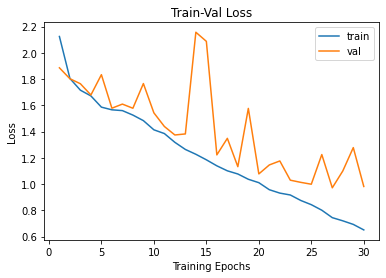

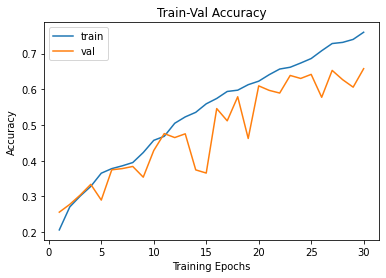

In [ ]:
# Train-Validation progress
num_epochs = params_train['num_epochs']

# plot loss progress
plt.title('Train-Val Loss')
plt.plot(range(1, num_epochs+1), loss_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), loss_hist['val'], label='val')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()

# plot accuracy progress
plt.title('Train-Val Accuracy')
plt.plot(range(1, num_epochs+1), metric_hist['train'], label='train')
plt.plot(range(1, num_epochs+1), metric_hist['val'], label='val')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.legend()
plt.show()